# بيتر والذئب: مقدمة في التعلم المعزز

في هذا الدرس، سنتعلم كيفية تطبيق التعلم المعزز على مشكلة إيجاد المسارات. الإعداد مستوحى من الحكاية الموسيقية [بيتر والذئب](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) التي ألفها الملحن الروسي [سيرجي بروكوفييف](https://en.wikipedia.org/wiki/Sergei_Prokofiev). إنها قصة عن بيتر، الشاب المغامر الذي يخرج بشجاعة من منزله إلى الغابة لمطاردة الذئب. سنقوم بتدريب خوارزميات تعلم الآلة التي ستساعد بيتر على استكشاف المنطقة المحيطة وبناء خريطة تنقل مثالية.

أولاً، دعونا نستورد مجموعة من المكتبات المفيدة:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## نظرة عامة على التعلم المعزز

**التعلم المعزز** (RL) هو تقنية تعلم تتيح لنا تعلم السلوك الأمثل لوكيل **agent** في بيئة **environment** معينة من خلال إجراء العديد من التجارب. يجب أن يكون لدى الوكيل في هذه البيئة **هدف** محدد بواسطة **دالة المكافأة**.

## البيئة

للتبسيط، دعونا نعتبر أن عالم بيتر عبارة عن لوحة مربعة بحجم `width` x `height`. كل خلية في هذه اللوحة يمكن أن تكون:
* **أرضًا**، يمكن لبيتر والمخلوقات الأخرى المشي عليها
* **ماء**، من الواضح أنه لا يمكنك المشي عليه
* **شجرة** أو **عشب** - مكان يمكن أن تأخذ فيه قسطًا من الراحة
* **تفاحة**، تمثل شيئًا يسر بيتر العثور عليه لإطعام نفسه
* **ذئب**، وهو خطر يجب تجنبه

للعمل مع البيئة، سنقوم بتعريف فئة تسمى `Board`. ولتجنب ازدحام هذا الدفتر بالكود، قمنا بنقل جميع الأكواد المتعلقة بالعمل مع اللوحة إلى وحدة منفصلة تسمى `rlboard`، والتي سنقوم الآن باستيرادها. يمكنك الاطلاع داخل هذه الوحدة للحصول على مزيد من التفاصيل حول آليات التنفيذ الداخلية.


In [2]:
from rlboard import *

لنقم الآن بإنشاء لوحة عشوائية ونرى كيف تبدو:


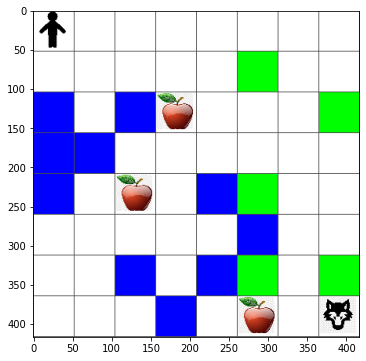

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## الإجراءات والسياسة

في مثالنا، هدف بيتر هو العثور على تفاحة، مع تجنب الذئب والعوائق الأخرى. لتحقيق ذلك، يمكنه ببساطة التجول حتى يجد تفاحة. لذلك، في أي موقع يمكنه اختيار واحدة من الإجراءات التالية: أعلى، أسفل، يسار، ويمين. سنقوم بتعريف هذه الإجراءات كقاموس، وربطها بأزواج من تغييرات الإحداثيات المقابلة. على سبيل المثال، التحرك يمينًا (`R`) سيقابل الزوج `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

استراتيجية وكيلنا (بيتر) تُعرّف بما يُسمى **السياسة**. دعونا نأخذ بعين الاعتبار أبسط سياسة تُسمى **المشي العشوائي**.

## المشي العشوائي

دعونا نبدأ بحل مشكلتنا من خلال تنفيذ استراتيجية المشي العشوائي.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

لنقم بتجربة السير العشوائي عدة مرات ونرى متوسط عدد الخطوات المتخذة:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## وظيفة المكافأة

لجعل سياستنا أكثر ذكاءً، نحتاج إلى فهم أي الحركات "أفضل" من غيرها.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## التعلم باستخدام Q-Learning

قم ببناء جدول Q، أو مصفوفة متعددة الأبعاد. بما أن لوحتنا لها أبعاد `width` x `height`، يمكننا تمثيل جدول Q باستخدام مصفوفة numpy ذات الشكل `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

مرر جدول Q إلى دالة الرسم من أجل تصور الجدول على اللوحة:


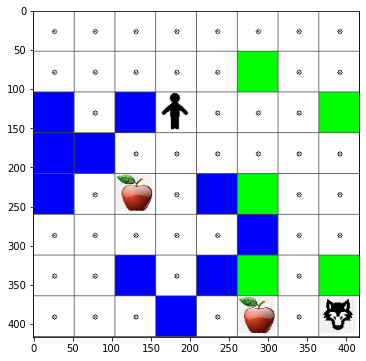

In [9]:
m.plot(Q)

## جوهر التعلم باستخدام Q-Learning: معادلة بيلمان وخوارزمية التعلم

اكتب كودًا شبه برمجي لخوارزمية التعلم الخاصة بنا:

* قم بتهيئة جدول Q بحيث يحتوي على أرقام متساوية لجميع الحالات والإجراءات
* قم بتعيين معدل التعلم $\alpha\leftarrow 1$
* كرر المحاكاة عدة مرات
   1. ابدأ من موقع عشوائي
   1. كرر
        1. اختر إجراءً $a$ في الحالة $s$
        2. نفذ الإجراء بالانتقال إلى حالة جديدة $s'$
        3. إذا واجهنا شرط نهاية اللعبة، أو كان إجمالي المكافأة صغيرًا جدًا - قم بإنهاء المحاكاة  
        4. احسب المكافأة $r$ في الحالة الجديدة
        5. قم بتحديث دالة Q وفقًا لمعادلة بيلمان: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. قم بتحديث إجمالي المكافأة وقلل $\alpha$.

## الاستغلال مقابل الاستكشاف

أفضل نهج هو تحقيق توازن بين الاستكشاف والاستغلال. مع تعلمنا المزيد عن بيئتنا، سنكون أكثر ميلًا لاتباع المسار الأمثل، ومع ذلك، يجب اختيار المسار غير المستكشف بين الحين والآخر.

## تنفيذ الخوارزمية باستخدام بايثون

الآن نحن جاهزون لتنفيذ خوارزمية التعلم. قبل ذلك، نحتاج أيضًا إلى بعض الوظائف التي تحول الأرقام العشوائية في جدول Q إلى متجه من الاحتمالات للإجراءات المقابلة:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

نضيف كمية صغيرة من `eps` إلى المتجه الأصلي لتجنب القسمة على 0 في الحالة الأولية، عندما تكون جميع مكونات المتجه متطابقة.

خوارزمية التعلم الفعلية التي سنقوم بتشغيلها لـ 5000 تجربة، والتي تُعرف أيضًا باسم **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

بعد تنفيذ هذا الخوارزمية، يجب تحديث جدول Q بقيم تحدد جاذبية الإجراءات المختلفة في كل خطوة. تصور الجدول هنا:


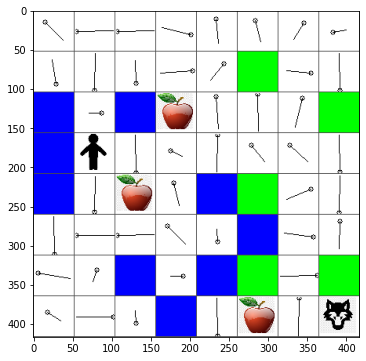

In [12]:
m.plot(Q)

## التحقق من السياسة

بما أن جدول Q يعرض "جاذبية" كل إجراء في كل حالة، فمن السهل جدًا استخدامه لتحديد التنقل الفعّال في عالمنا. في أبسط الحالات، يمكننا ببساطة اختيار الإجراء الذي يتوافق مع أعلى قيمة في جدول Q:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

إذا جربت الكود أعلاه عدة مرات، قد تلاحظ أنه أحيانًا "يتوقف" عن العمل، وتحتاج إلى الضغط على زر الإيقاف في الدفتر لمقاطعته.

> **المهمة 1:** قم بتعديل دالة `walk` لتحديد الحد الأقصى لطول المسار بعدد معين من الخطوات (على سبيل المثال، 100)، وراقب الكود أعلاه يعيد هذه القيمة من وقت لآخر.

> **المهمة 2:** قم بتعديل دالة `walk` بحيث لا تعود إلى الأماكن التي زارتها مسبقًا. هذا سيمنع `walk` من التكرار في نفس الأماكن، ومع ذلك، قد ينتهي الأمر بالوكيل "محاصرًا" في موقع لا يستطيع الهروب منه.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


## التحقيق في عملية التعلم


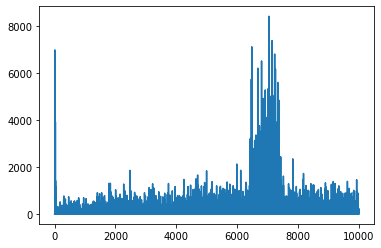

In [15]:
plt.plot(lpath)

ما نلاحظه هنا هو أنه في البداية زاد متوسط طول المسار. ربما يعود ذلك إلى حقيقة أننا عندما لا نعرف شيئًا عن البيئة - فمن المحتمل أن نقع في حالات سيئة، مثل الوقوع في الماء أو مواجهة الذئب. ومع تعلمنا المزيد وبدء استخدام هذه المعرفة، يمكننا استكشاف البيئة لفترة أطول، ولكننا لا نزال غير مدركين تمامًا لمواقع التفاح.

بمجرد أن نتعلم بما يكفي، يصبح من الأسهل على الوكيل تحقيق الهدف، ويبدأ طول المسار في الانخفاض. ومع ذلك، لا نزال منفتحين على الاستكشاف، لذا غالبًا ما ننحرف عن أفضل مسار ونستكشف خيارات جديدة، مما يجعل المسار أطول من المثالي.

ما نلاحظه أيضًا في هذا الرسم البياني هو أنه في نقطة معينة زاد الطول بشكل مفاجئ. يشير هذا إلى الطبيعة العشوائية للعملية، وأنه يمكننا في بعض الأحيان "إفساد" معاملات Q-Table عن طريق استبدالها بقيم جديدة. يجب تقليل هذا الأمر قدر الإمكان عن طريق تقليل معدل التعلم (أي أنه مع اقتراب نهاية التدريب نقوم فقط بتعديل قيم Q-Table بقيمة صغيرة).

بشكل عام، من المهم أن نتذكر أن نجاح وجودة عملية التعلم تعتمد بشكل كبير على المعاملات، مثل معدل التعلم، وتناقص معدل التعلم، ومعامل الخصم. غالبًا ما يُطلق على هذه المعاملات اسم **المعاملات الفائقة**، لتمييزها عن **المعاملات** التي نقوم بتحسينها أثناء التدريب (مثل معاملات Q-Table). تُعرف عملية العثور على أفضل قيم للمعاملات الفائقة باسم **تحسين المعاملات الفائقة**، وهي تستحق أن تكون موضوعًا منفصلًا.


## التمرين
#### عالم أكثر واقعية لقصة بيتر والذئب

في وضعنا الحالي، كان بيتر قادرًا على التحرك تقريبًا دون أن يشعر بالتعب أو الجوع. في عالم أكثر واقعية، عليه أن يجلس ويرتاح من وقت لآخر، وأيضًا أن يطعم نفسه. دعونا نجعل عالمنا أكثر واقعية من خلال تنفيذ القواعد التالية:

1. عند الانتقال من مكان إلى آخر، يفقد بيتر **الطاقة** ويكتسب بعض **الإرهاق**.
2. يمكن لبيتر أن يكتسب المزيد من الطاقة عن طريق تناول التفاح.
3. يمكن لبيتر التخلص من الإرهاق عن طريق الراحة تحت الشجرة أو على العشب (أي المشي إلى موقع على اللوحة يحتوي على شجرة أو عشب - حقل أخضر).
4. يحتاج بيتر إلى العثور على الذئب وقتله.
5. لكي يتمكن بيتر من قتل الذئب، يجب أن تكون لديه مستويات معينة من الطاقة والإرهاق، وإلا فإنه سيخسر المعركة.

قم بتعديل وظيفة المكافأة أعلاه وفقًا لقواعد اللعبة، وقم بتشغيل خوارزمية التعلم المعزز لتعلم أفضل استراتيجية للفوز باللعبة، وقارن نتائج المشي العشوائي مع نتائج خوارزميتك من حيث عدد الألعاب التي تم الفوز بها والخسارة.

> **ملاحظة**: قد تحتاج إلى ضبط معلمات التعلم لجعلها تعمل، خاصة عدد العصور التدريبية. نظرًا لأن نجاح اللعبة (مواجهة الذئب) هو حدث نادر، يمكنك توقع وقت تدريب أطول بكثير.



---

**إخلاء المسؤولية**:  
تمت ترجمة هذا المستند باستخدام خدمة الترجمة الآلية [Co-op Translator](https://github.com/Azure/co-op-translator). بينما نسعى لتحقيق الدقة، يرجى العلم أن الترجمات الآلية قد تحتوي على أخطاء أو معلومات غير دقيقة. يجب اعتبار المستند الأصلي بلغته الأصلية هو المصدر الموثوق. للحصول على معلومات حساسة أو هامة، يُوصى بالاستعانة بترجمة بشرية احترافية. نحن غير مسؤولين عن أي سوء فهم أو تفسيرات خاطئة تنشأ عن استخدام هذه الترجمة.
